In [ ]:
from google.colab import files

uploaded = files.upload()

Saving compressed_data (1).csv.gz to compressed_data (1).csv (1).gz


In [ ]:
import pandas as pd
df = pd.read_csv("compressed_data (1).csv.gz")

In [ ]:
df.sample(5)

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
156347,8/29/2014 11:02,Male,Canada,Student,No,Yes,No,31-60 days,Yes,Yes,Yes,Low,No,Maybe,No,No,Yes
138716,8/27/2014 12:54,Male,United States,Business,No,No,Yes,15-30 days,Yes,Maybe,Yes,Medium,No,Maybe,Yes,No,No
250911,8/28/2014 11:04,Male,United States,Housewife,No,Yes,Yes,1-14 days,No,Yes,No,High,Yes,No,Yes,Maybe,Yes
284678,8/28/2014 0:43,Male,United States,Business,No,Yes,Yes,More than 2 months,Maybe,Maybe,Maybe,Low,No,No,Maybe,No,Yes
118425,8/27/2014 12:58,Male,Ireland,Corporate,No,No,No,Go out Every day,Yes,No,Yes,Medium,No,No,Maybe,No,Yes


In [ ]:
df.shape

(292364, 17)

In [ ]:
df.isnull().sum()

,0
Timestamp,0
Gender,0
Country,0
Occupation,0
self_employed,5202
family_history,0
treatment,0
Days_Indoors,0
Growing_Stress,0
Changes_Habits,0


In [ ]:
df['self_employed'] = df['self_employed'].fillna('Unknown')

In [ ]:
df.duplicated().sum()

np.int64(2313)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df = df.drop(columns=['Timestamp', 'Country'])

In [ ]:
# basic yes/no
binary_map = {'Yes': 1, 'No': 0}

df['family_history'] = df['family_history'].map(binary_map)
df['treatment'] = df['treatment'].map(binary_map)

# self employed (with unknown)
df['self_employed'] = df['self_employed'].map({
    'Yes': 1,
    'No': 0,
    'Unknown': -1
})

In [ ]:
binary_map_extended = {
    'Yes': 1,
    'No': 0,
    'Maybe': -1,
    'Not sure': -1
}

df['mental_health_interview'] = df['mental_health_interview'].map(binary_map_extended)
df['care_options'] = df['care_options'].map(binary_map_extended)
df['Mental_Health_History'] = df['Mental_Health_History'].map(binary_map_extended)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_features = ['Growing_Stress', 'Mood_Swings']

ordinal_encoder = OrdinalEncoder(
    categories=[['Low', 'Medium', 'High'], ['Low', 'Medium', 'High']],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

df[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

multi_cols = [
    'Days_Indoors',
    'Changes_Habits',
    'Coping_Struggles',
    'Work_Interest',
    'Social_Weakness',
    'Gender',
    'Occupation'
]

for col in multi_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [ ]:
df.isnull().sum()

,0
Gender,0
Occupation,0
self_employed,0
family_history,0
treatment,0
Days_Indoors,0
Growing_Stress,0
Changes_Habits,0
Mental_Health_History,0
Mood_Swings,0


In [ ]:
X = df.drop(columns=['treatment'])
y = df['treatment']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced']
}

lr = LogisticRegression(max_iter=1000, random_state=42)

lr_grid = GridSearchCV(
    lr,
    lr_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_

print("Best Logistic Regression params:", lr_grid.best_params_)

Best Logistic Regression params: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}


In [ ]:
# RandomForest trained with manually selected hyperparameters
# GridSearch / RandomSearch skipped due to time & resource constraints
# Dataset size (~290k rows) makes exhaustive tuning impractical on Colab

from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=1
)

best_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=1, random_state=42)

In [ ]:
# XGBoost with manually tuned hyperparameters
# Hyperparameter search skipped due to high computational cost

from xgboost import XGBClassifier

best_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=1
)

best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)

voting_model.fit(X_train, y_train)

In [92]:
y_pred = voting_model.predict(X_test)

In [93]:
# --- Evaluation ---

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7051938425471032

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.66      0.69     28774
           1       0.69      0.75      0.72     29237

    accuracy                           0.71     58011
   macro avg       0.71      0.70      0.70     58011
weighted avg       0.71      0.71      0.70     58011


Confusion Matrix:
 [[18969  9805]
 [ 7297 21940]]


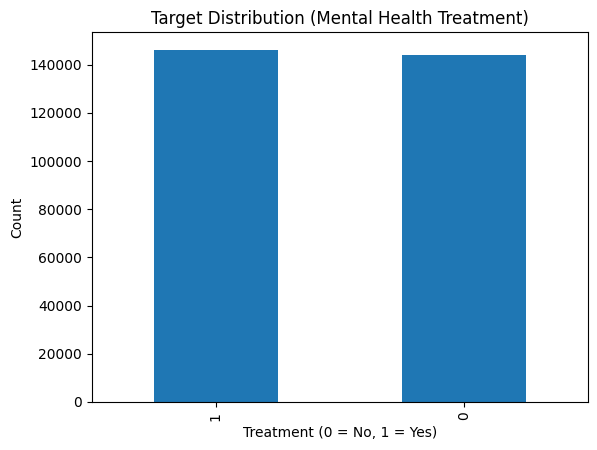

In [94]:
import matplotlib.pyplot as plt

y.value_counts().plot(kind='bar')
plt.title("Target Distribution (Mental Health Treatment)")
plt.xlabel("Treatment (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

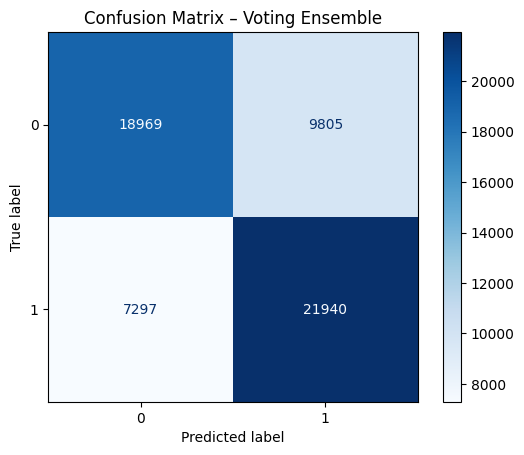

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues'
)
plt.title("Confusion Matrix – Voting Ensemble")
plt.show()

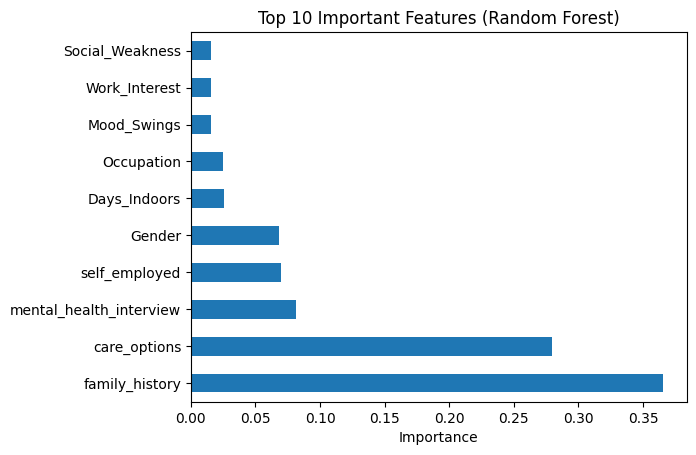

In [96]:
import pandas as pd

importances = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(10).plot(kind='barh')
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.show()

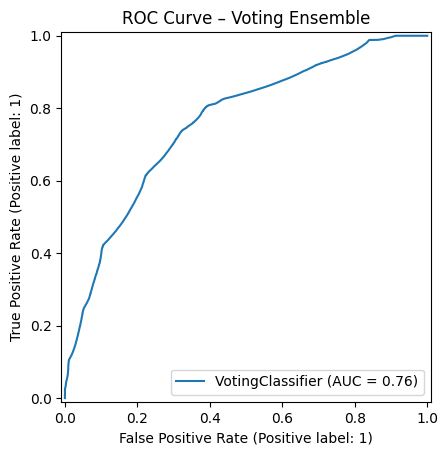

In [97]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
    voting_model,
    X_test,
    y_test
)
plt.title("ROC Curve – Voting Ensemble")
plt.show()

In [98]:
label_encoders = {}

from sklearn.preprocessing import LabelEncoder

for col in multi_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [99]:
import joblib

# Save trained voting model
joblib.dump(voting_model, "/content/mental_health_model.pkl")

# Save ordinal encoder
joblib.dump(ordinal_encoder, "/content/ordinal_encoder.pkl")

# Save label encoders
joblib.dump(label_encoders, "/content/label_encoders.pkl")

# Save feature columns (VERY IMPORTANT)
joblib.dump(X.columns.tolist(), "/content/feature_columns.pkl")

print("Model and preprocessors saved successfully")

Model and preprocessors saved successfully


In [100]:
from google.colab import files

files.download("/content/mental_health_model.pkl")
files.download("/content/ordinal_encoder.pkl")
files.download("/content/label_encoders.pkl")
files.download("/content/feature_columns.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>